In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from Bio.Data import CodonTable
# from Bio.Data.CodonTable import NCBICodonTableDNA
# from Bio import SeqIO
from scipy import spatial

# from mutspec.annotation import (
#     calculate_mutspec, CodonAnnotation, mutations_summary, 
#     translator, rev_comp, lbl2lbl_id, lbl_id2lbl
# )
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
# from mutspec.io import read_genbank_ref
# from mutspec.draw.mut import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

In [7]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print("#species", mutspec.Species.nunique())
print(mutspec.shape)
mutspec.head()

#species 974
(187008, 10)


,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


## Drop species with low number of observed mutations!

In [8]:
sp_count = mutspec.groupby("Species").Observed.sum()

MIN_MUT_NUM = 30
mutspec = mutspec[mutspec.Species.isin(sp_count[sp_count > MIN_MUT_NUM].index)]
print("#species", mutspec.Species.nunique())
mutspec.shape[0]

#species 700


134400

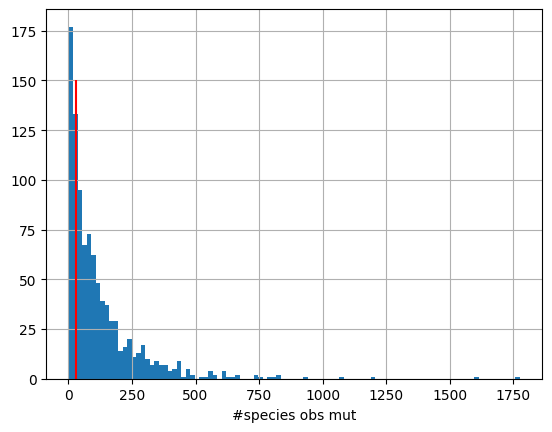

In [43]:
sp_count.hist(bins=100)
plt.xlabel("#species obs mut");
plt.vlines([30], 0, 150, 'r')

In [14]:
sp2mut = mutspec.pivot(index=["Class", "Species"], columns="Mut", values="MutSpec")
sp2mut = sp2mut[possible_sbs192]
sp2mut.head().round(2)

Mut                                        A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis            0.00      0.0      0.0      0.0   
               Abramis_brama                  0.00      0.0      0.0      0.0   
               Acanthopagrus_schlegelii       0.01      0.0      0.0      0.0   
               Acheilognathus_macropterus     0.00      0.0      0.0      0.0   
               Acheilognathus_rhombeus        0.00      0.0      0.0      0.0   

Mut                                        C[A>C]A  C[A>C]C  C[A>C]G  C[A>C]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0     0.00      0.0   
               Abramis_brama                   0.0      0.0     0.00      0.0   
               Acanthopagrus_schlegelii        0.0      0.0     0.01      0.0   
               Acheilognathus_macropterus      0.0      0.0     0.00      0.0   
               Acheilognathus_rhombeus         0.0      0.0     0.00      0.0   

Mut                                        G[A>C]A  G[A>C]C  ...  C[T>G]G  \
Class          Species                                       ...            
Actinopterygii Abbottina_rivularis             0.0      0.0  ...     0.00   
               Abramis_brama                   0.0      0.0  ...     0.00   
               Acanthopagrus_schlegelii        0.0      0.0  ...     0.01   
               Acheilognathus_macropterus      0.0      0.0  ...     0.00   
               Acheilognathus_rhombeus         0.0      0.0  ...     0.00   

Mut                                        C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0     0.00      0.0      0.0   
               Abramis_brama                   0.0     0.00      0.0      0.0   
               Acanthopagrus_schlegelii        0.0     0.01      0.0      0.0   
               Acheilognathus_macropterus      0.0     0.00      0.0      0.0   
               Acheilognathus_rhombeus         0.0     0.00      0.0      0.0   

Mut                                        G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0      0.0      0.0   
               Abramis_brama                   0.0      0.0      0.0      0.0   
               Acanthopagrus_schlegelii        0.0      0.0      0.0      0.0   
               Acheilognathus_macropterus      0.0      0.0      0.0      0.0   
               Acheilognathus_rhombeus         0.0      0.0      0.0      0.0   

Mut                                        T[T>G]T  
Class          Species                              
Actinopterygii Abbottina_rivularis             0.0  
               Abramis_brama                   0.0  
               Acanthopagrus_schlegelii        0.0  
               Acheilognathus_macropterus      0.0  
               Acheilognathus_rhombeus         0.0  

[5 rows x 192 columns]

## clustermap

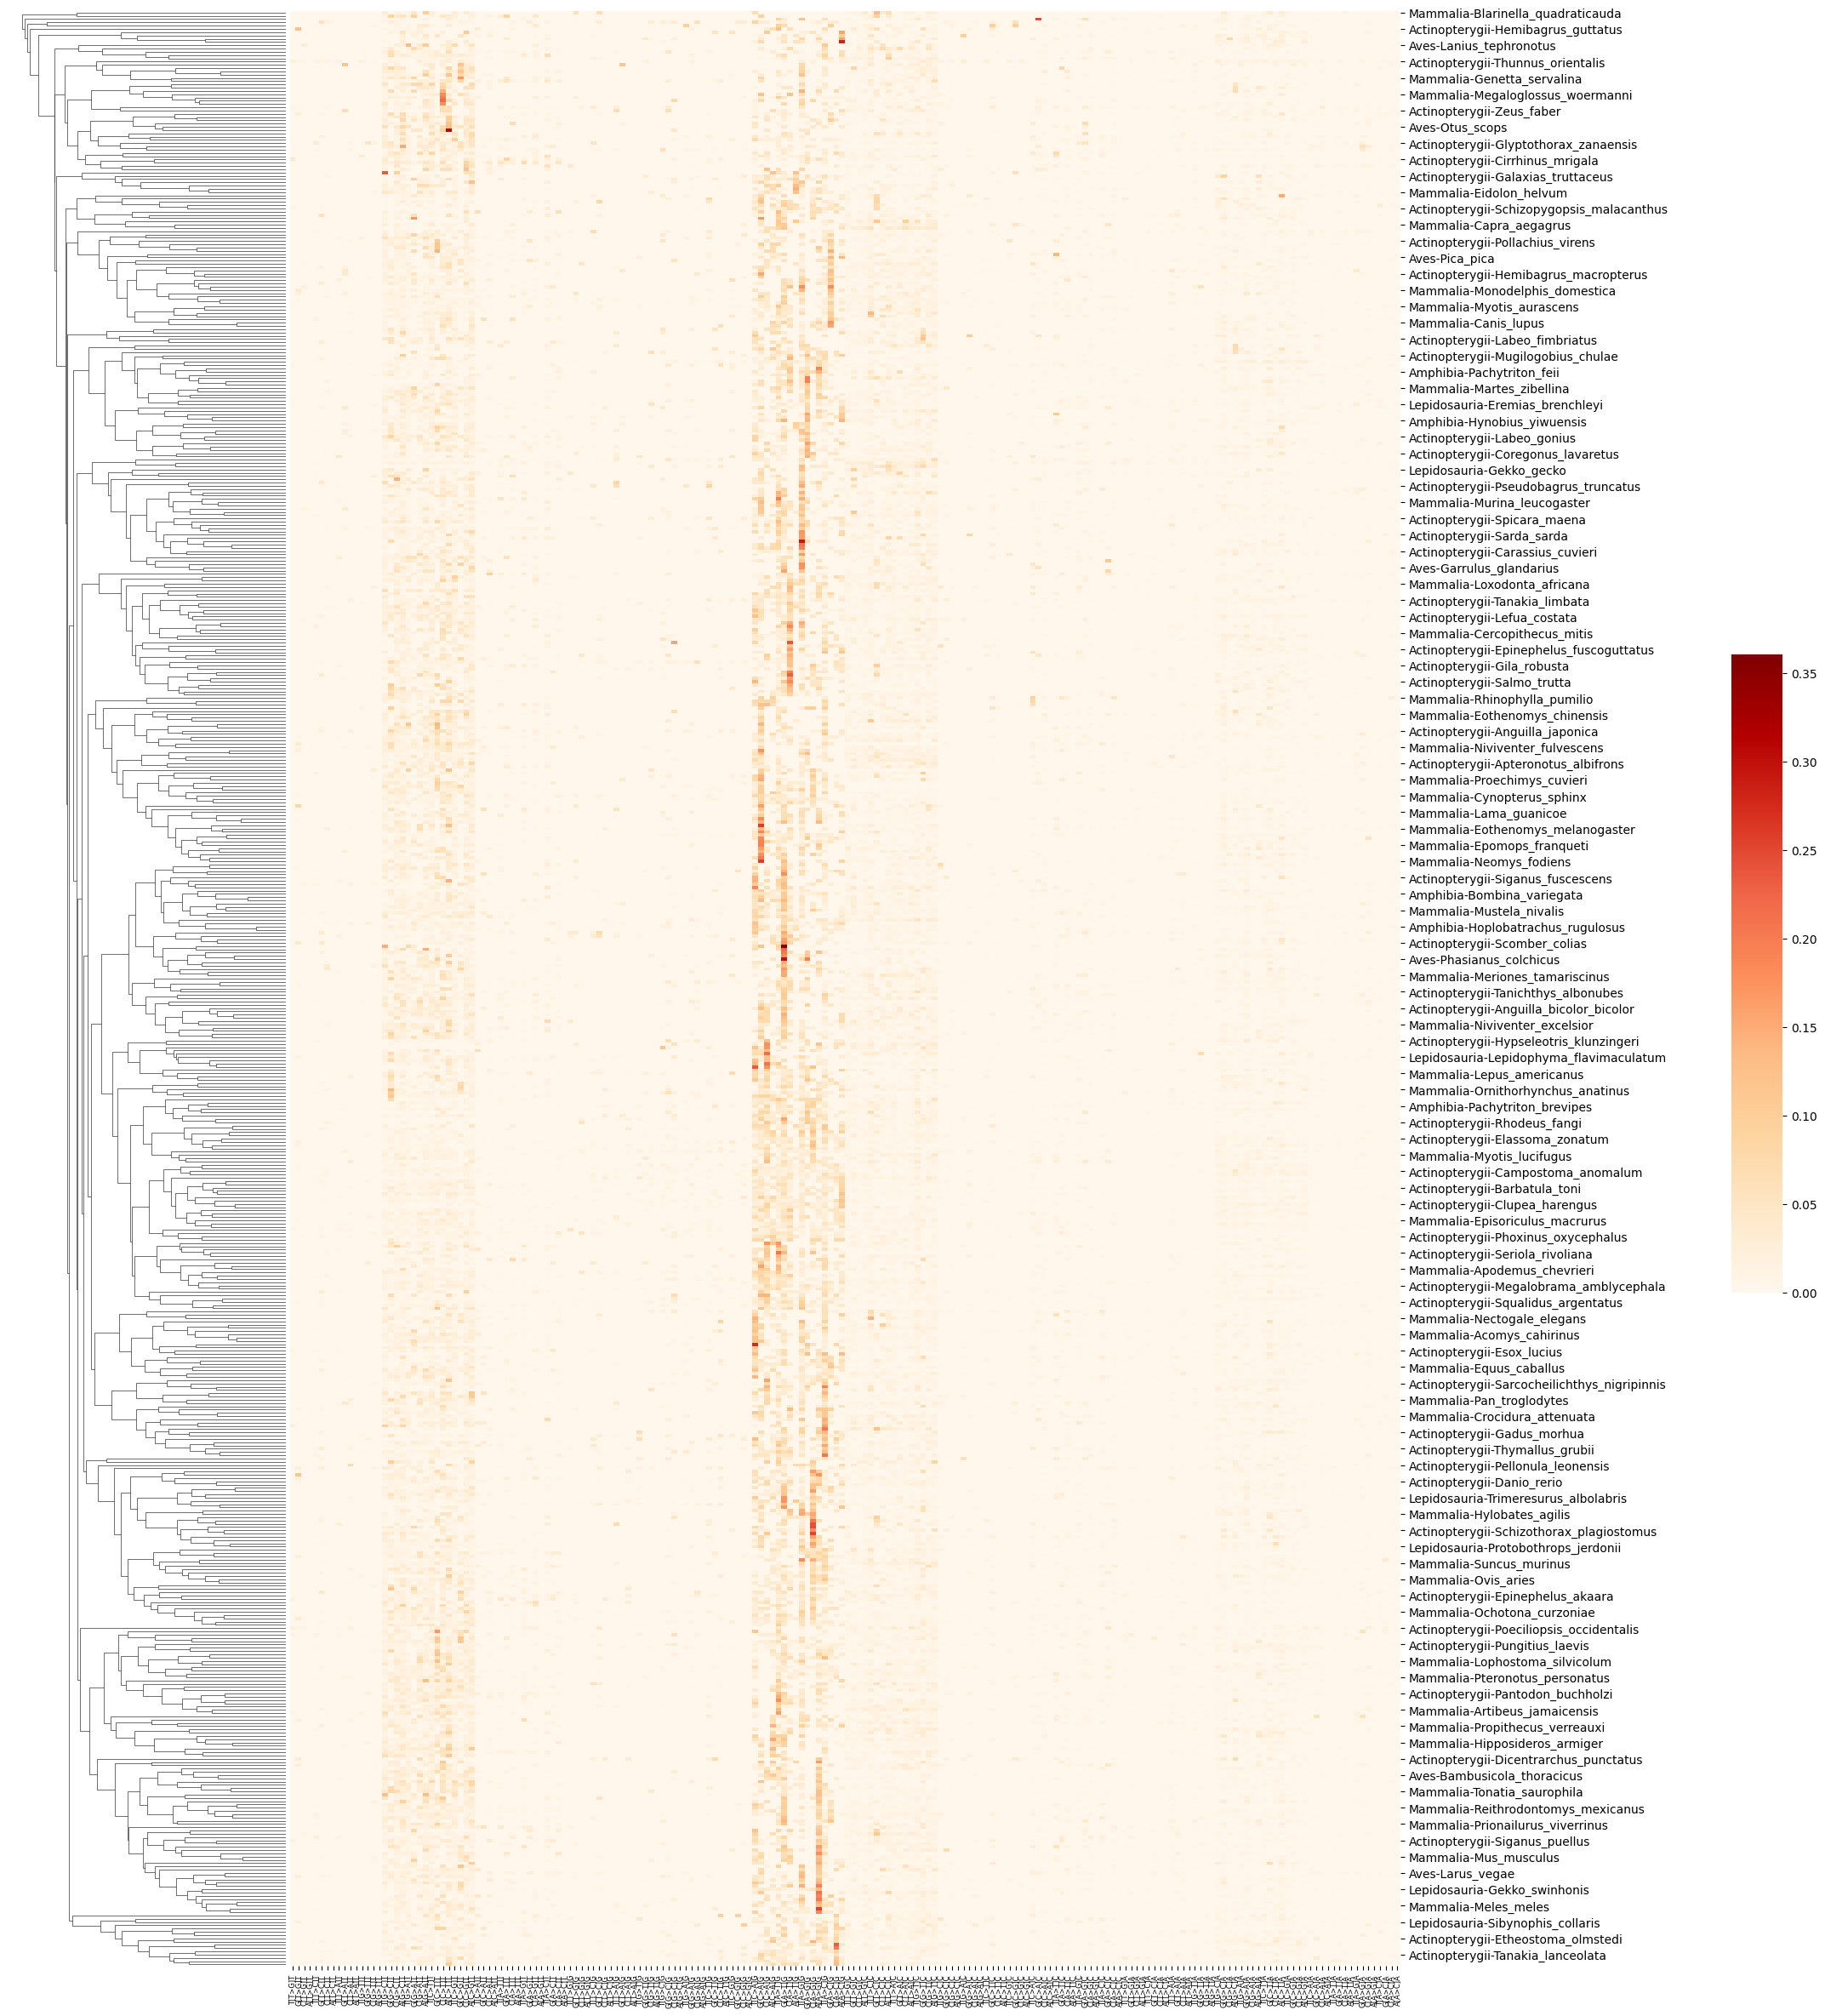

In [64]:
grd = sns.clustermap(
    data=sp2mut, 
    # pivot_kws=dict(index=["Class", "Species"], columns="Mut", values="MutSpec"), 
    col_cluster=False,
    metric=spatial.distance.cosine,
    xticklabels=mutspec.Mut.unique(),
    cmap="OrRd",
    figsize=(20, 30),
    cbar_pos=(1.02, 0.3, 0.03, 0.25),
)
grd.ax_col_dendrogram.remove()
grd.ax_heatmap.set_ylabel("")
grd.ax_heatmap.set_xlabel("")
plt.setp(grd.ax_heatmap.get_xticklabels(), size=6,)
# plt.tight_layout()
# grd.savefig("../pictures/dendromap.pdf")
plt.show()

## Redusing dimensions

### Filter out transversions

In [ ]:
import pymutspec

transitions = [x for x in pymutspec.constants.possible_sbs192 if x[2:5] in {"C>T", "T>C", "A>G", "G>A"}]
len(transitions)

64

In [ ]:
df = df[transitions]

### UMAP & TSNE

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [31]:
pca = PCA()
X_pca = pca.fit_transform(df)
pca.explained_variance_ratio_[:40].sum()

0.9716185192191391

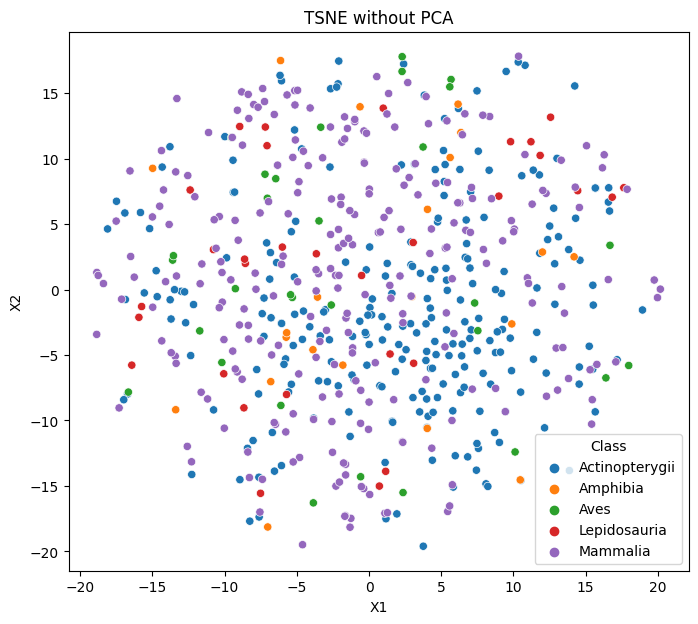

In [32]:
tsne = TSNE(2, n_jobs=12)
X_tsne = tsne.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title("TSNE without PCA")
plt.show()

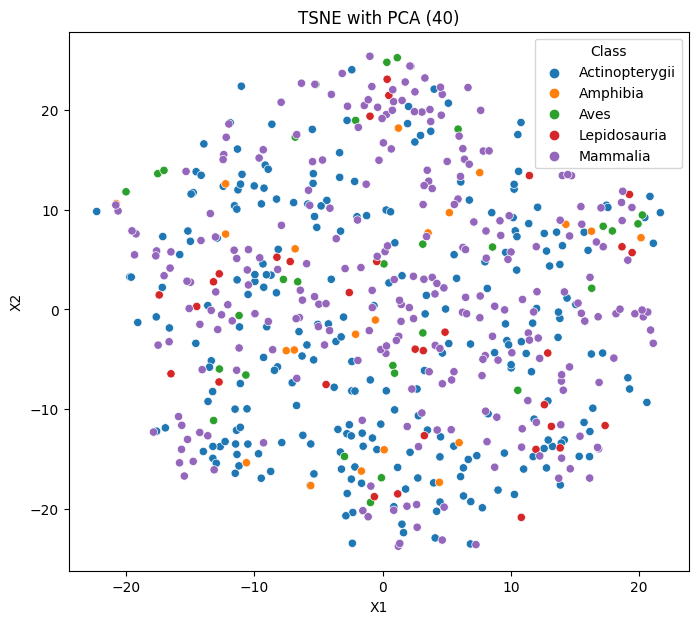

In [34]:
nfea = 40
tsne = TSNE(2, n_jobs=12, metric="cosine")
X_tsne = tsne.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"TSNE with PCA ({nfea})")
plt.show()

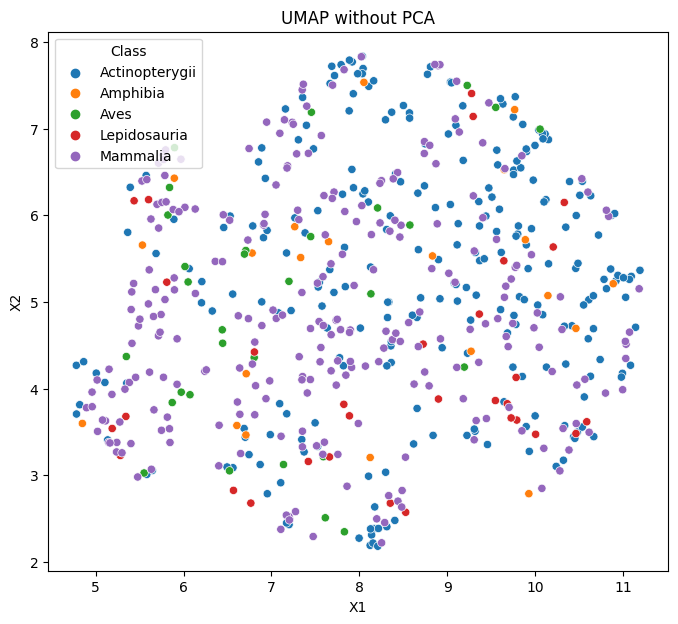

In [35]:
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP without PCA")
plt.show()

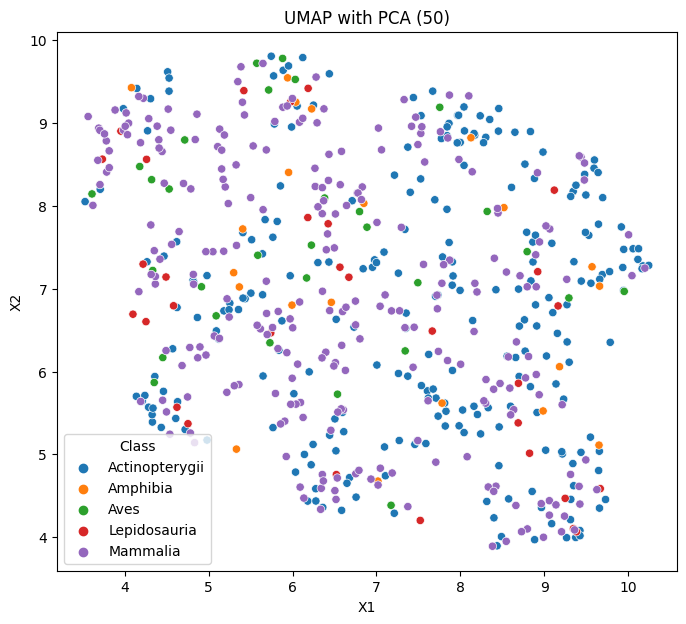

In [37]:
nfea = 50
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP with PCA ({nfea})")
plt.show()

## Pairwise species-specific comparison

In [19]:
from scipy.spatial.distance import pdist, cdist, squareform

In [46]:
sp_sim = pd.DataFrame(1 - squareform(pdist(sp2mut, "cosine")), index=sp2mut.index, columns=sp2mut.index)

In [155]:
sp_sim.index.get_level_values(0).map(dict(zip(sp_sim.index.levels[0], "rgbkp")))

Index(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       ...
       'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
      dtype='object', name='Class', length=700)

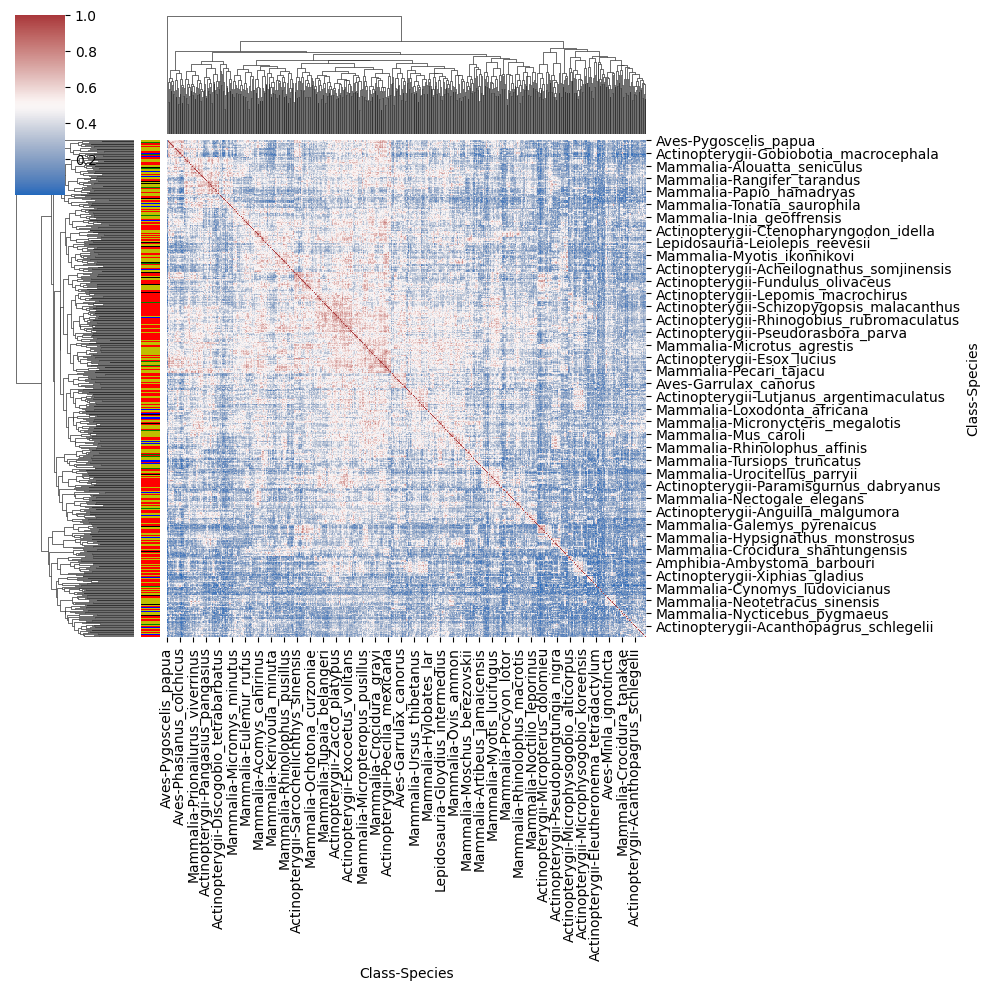

In [158]:
sns.clustermap(sp_sim, cmap="vlag", row_colors=sp_sim.index.get_level_values(0).map(dict(zip(sp_sim.index.levels[0], "rgbky"))))

Cannot see class similarities

In [68]:
sp_sim

Class                                          Actinopterygii                \
Species                                   Abbottina_rivularis Abramis_brama   
Class          Species                                                        
Actinopterygii Abbottina_rivularis                   1.000000      0.510502   
               Abramis_brama                         0.510502      1.000000   
               Acanthopagrus_schlegelii              0.204972      0.159649   
               Acheilognathus_macropterus            0.608835      0.291433   
               Acheilognathus_rhombeus               0.451981      0.472703   
...                                                       ...           ...   
Mammalia       Varecia_variegata                     0.448327      0.396183   
               Vicugna_vicugna                       0.316365      0.153717   
               Viverricula_indica                    0.215199      0.168091   
               Vulpes_lagopus                        0.463401      0.616639   
               Vulpes_vulpes                         0.305785      0.131562   

Class                                                               \
Species                                   Acanthopagrus_schlegelii   
Class          Species                                               
Actinopterygii Abbottina_rivularis                        0.204972   
               Abramis_brama                              0.159649   
               Acanthopagrus_schlegelii                   1.000000   
               Acheilognathus_macropterus                 0.314079   
               Acheilognathus_rhombeus                    0.278518   
...                                                            ...   
Mammalia       Varecia_variegata                          0.178373   
               Vicugna_vicugna                            0.217840   
               Viverricula_indica                         0.422014   
               Vulpes_lagopus                             0.178465   
               Vulpes_vulpes                              0.381787   

Class                                                                 \
Species                                   Acheilognathus_macropterus   
Class          Species                                                 
Actinopterygii Abbottina_rivularis                          0.608835   
               Abramis_brama                                0.291433   
               Acanthopagrus_schlegelii                     0.314079   
               Acheilognathus_macropterus                   1.000000   
               Acheilognathus_rhombeus                      0.544638   
...                                                              ...   
Mammalia       Varecia_variegata                            0.283690   
               Vicugna_vicugna                              0.318086   
               Viverricula_indica                           0.363713   
               Vulpes_lagopus                               0.167033   
               Vulpes_vulpes                                0.440106   

Class                                                              \
Species                                   Acheilognathus_rhombeus   
Class          Species                                              
Actinopterygii Abbottina_rivularis                       0.451981   
               Abramis_brama                             0.472703   
               Acanthopagrus_schlegelii                  0.278518   
               Acheilognathus_macropterus                0.544638   
               Acheilognathus_rhombeus                   1.000000   
...                                                           ...   
Mammalia       Varecia_variegata                         0.445127   
               Vicugna_vicugna                           0.584507   
               Viverricula_indica                        0.333322   
               Vulpes_lagopus                            0.397379   
      

In [196]:
data = []
for cl1 in sp_sim.index.levels[0]:
    for cl2 in sp_sim.index.levels[0]:
        if cl1 == cl2:
            cur_sims = 1 - pdist(sp2mut.loc[cl1], "cosine")
        else:
            cur_sims = 1 - cdist(sp2mut.loc[cl1], sp2mut.loc[cl2], "cosine").flatten()
        data.append([cl1, cl2, cur_sims])

cls_sims = pd.DataFrame(data, columns=["cls1", "cls2", "pp_sims"])

In [198]:
cls_sims.head()

,cls1,cls2,pp_sims
0,Actinopterygii,Actinopterygii,"[0.5105016710500526, 0.20497179235784468, 0.60..."
1,Actinopterygii,Amphibia,"[0.20888842703274824, 0.20999189818591324, 0.3..."
2,Actinopterygii,Aves,"[0.48238511560987185, 0.5691001007851193, 0.51..."
3,Actinopterygii,Lepidosauria,"[0.1782423571624796, 0.2835929822453318, 0.405..."
4,Actinopterygii,Mammalia,"[0.4386866522532392, 0.3430308874656821, 0.558..."


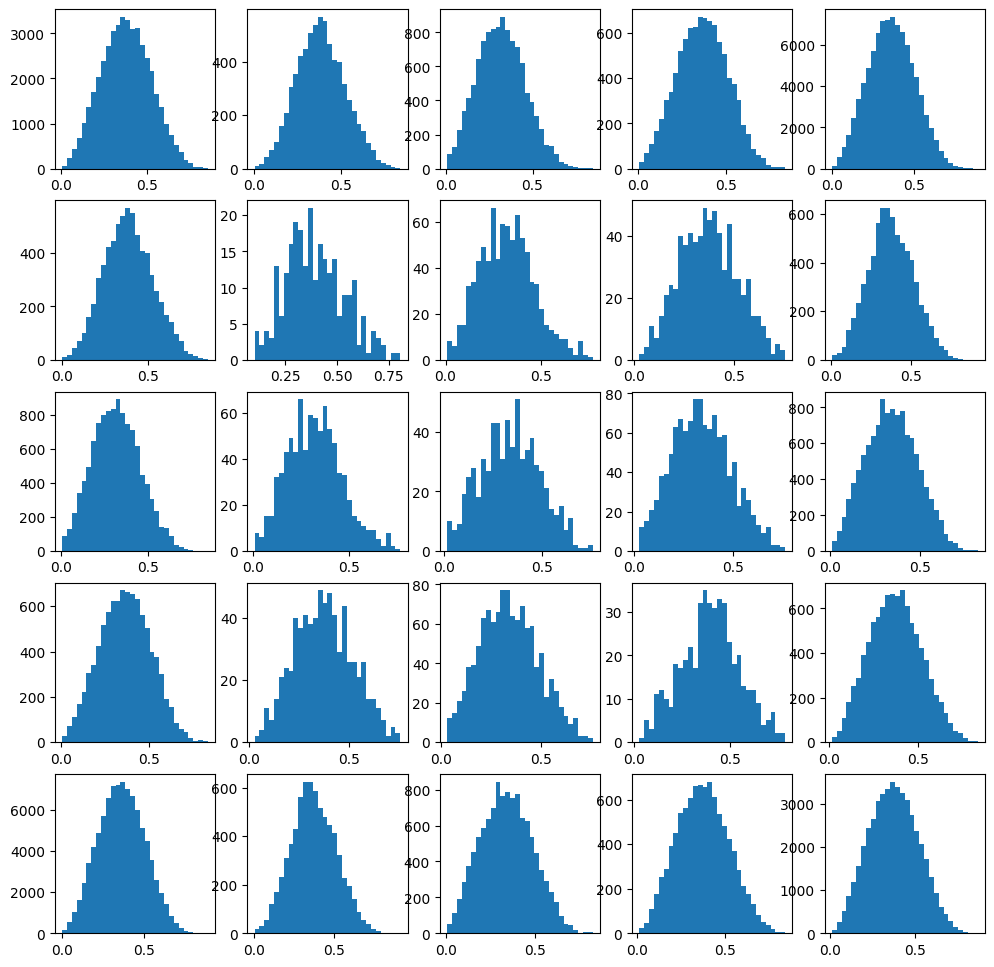

In [199]:
plt.figure(figsize=(12, 12))
for i, cl1 in enumerate(sp_sim.index.levels[0], 1):
    for j, cl2 in enumerate(sp_sim.index.levels[0], 1):
        plt.subplot(5, 5, (i-1)*5+j)
        plt.hist(cls_sims[(cls_sims.cls1 == cl1) & (cls_sims.cls2 == cl2)].pp_sims.item(), bins=30)

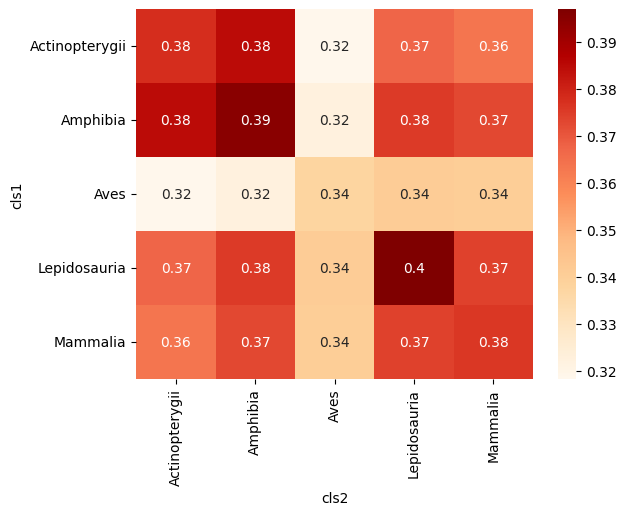

In [201]:
sns.heatmap(cls_sims.set_index(["cls1", "cls2"]).pp_sims.apply(np.mean).unstack(), annot=True, cmap="OrRd");